In [144]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"  

import matplotlib
#matplotlib.use('Agg')  # No GUI calls

import matplotlib.pyplot as plt

In [145]:
import torch
from torch import nn
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [167]:
batch_size=32

In [184]:
data_output = pd.read_csv("C:/Users/met48/Desktop/TS-Clustering/SimData/epsteinCV_outputs_active.csv", header=None)

scaler = MinMaxScaler()
data_output_scaled = scaler.fit_transform(data_output)
data_output = pd.DataFrame(data_output_scaled)

# --- Load the conditioning input parameters ---
data_input = pd.read_csv("C:/Users/met48/Desktop/TS-Clustering/SimData/epsteinCV_inputs.csv", sep=" ", header=None)

# --- Combine input + output ---
data = pd.concat([data_input, data_output], axis=1)

# --- Sample to 1280 examples if needed ---
data = data.sample(n=10000, random_state=1)

# --- Split into training and validation sets ---
train_data_pd, valid_data = train_test_split(data, test_size=0.2, random_state=42)

# --- Extract tensors for training ---
train_inputs = torch.tensor(train_data_pd.iloc[:, :3].values, dtype=torch.float32)
train_outputs = torch.tensor(train_data_pd.iloc[:, 3:].values, dtype=torch.float32)

valid_inputs = torch.tensor(valid_data.iloc[:, :3].values, dtype=torch.float32)
valid_outputs = torch.tensor(valid_data.iloc[:, 3:].values, dtype=torch.float32)

In [185]:
data

,0,1,2,0,1,2,3,4,5,6,...,242,243,244,245,246,247,248,249,250,251
30239,0.721832,0.106032,0.315410,0.0,0.088904,0.000000,0.000000,0.001378,0.000689,0.000000,...,0.000000,0.000689,0.000689,0.002757,0.002757,0.002068,0.000689,0.000689,0.002068,0.002757
13381,0.926782,0.043385,0.473899,0.0,0.314955,0.543763,0.549276,0.508615,0.462440,0.407994,...,0.013784,0.019297,0.019297,0.021365,0.033081,0.042040,0.026878,0.027567,0.023432,0.025500
29424,0.913186,0.080047,0.554347,0.0,0.068229,0.004824,0.000689,0.000000,0.000689,0.000000,...,0.000000,0.000689,0.000689,0.001378,0.000000,0.001378,0.004135,0.001378,0.000689,0.000689
3624,0.799078,0.043411,0.749577,0.0,0.013784,0.000689,0.002068,0.001378,0.000689,0.000000,...,0.017919,0.010338,0.008270,0.002757,0.000000,0.000689,0.000689,0.001378,0.001378,0.003446
24564,0.508585,0.216760,0.014888,0.0,0.034459,0.000000,0.000000,0.000000,0.000689,0.000000,...,0.001378,0.000000,0.000689,0.000000,0.000000,0.000689,0.000000,0.001378,0.000689,0.000689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30883,0.935056,0.026640,0.845832,0.0,0.022743,0.015851,0.009649,0.013784,0.016540,0.019986,...,0.016540,0.011027,0.008959,0.006892,0.007581,0.007581,0.000689,0.000000,0.006203,0.007581
18677,0.941053,0.030161,0.617472,0.0,0.301172,0.547898,0.568573,0.552033,0.527223,0.506547,...,0.161268,0.147484,0.139904,0.138525,0.148863,0.146795,0.139214,0.137147,0.117161,0.133012
13826,0.608192,0.314778,0.322039,0.0,0.011716,0.000000,0.000689,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000689,0.000000,0.002068,0.000000,0.000689
44596,0.684377,0.282162,0.435377,0.0,0.006892,0.000000,0.000000,0.000000,0.000000,0.000689,...,0.001378,0.000000,0.000689,0.000000,0.000000,0.000689,0.000000,0.000689,0.000000,0.000689


In [186]:
train_inputs.shape[0]

8000

In [187]:
torch.manual_seed(1)

In [188]:
train_data_length = train_inputs.shape[0]
train_data = torch.from_numpy(train_data_pd.values).float().to('cpu')
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
train_data.shape

torch.Size([8000, 255])

In [189]:
from torch.utils.data import Dataset

class ConditionalTimeSeriesDataset(Dataset):
    def __init__(self, time_series_data, condition_data):
        """
        time_series_data: Tensor of shape (N, 252)
        condition_data: Tensor of shape (N, 3)
        """
        self.time_series_data = time_series_data
        self.condition_data = condition_data

    def __len__(self):
        return len(self.time_series_data)

    def __getitem__(self, idx):
        return self.time_series_data[idx], self.condition_data[idx]

In [190]:
from torch.utils.data import DataLoader

train_dataset = ConditionalTimeSeriesDataset(train_outputs, train_inputs)
valid_dataset = ConditionalTimeSeriesDataset(valid_outputs, valid_inputs)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

In [191]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_dim=252, condition_dim=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x, conditions):
        # Concatenate time series and condition
        x = torch.cat([x, conditions], dim=1)
        return self.model(x)

In [192]:
discriminator = ConditionalDiscriminator()

In [193]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, condition_dim=3, output_dim=252):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, z, conditions):
        # Concatenate noise and condition
        x = torch.cat([z, conditions], dim=1)
        return self.model(x)

generator = ConditionalGenerator()

In [194]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [195]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [196]:
for epoch in range(num_epochs):
    for n, (real_samples, condition_vectors) in enumerate(train_loader):
        # real_samples: (batch_size, 252)
        # condition_vectors: (batch_size, 3)

        real_samples_labels = torch.ones((batch_size, 1))
        generated_samples_labels = torch.zeros((batch_size, 1))

        # Sample latent space
        latent_dim = 100
        latent_space_samples = torch.randn((batch_size, latent_dim))  # Latent space dimension

        # Ensure condition_vectors has the same batch size as latent_space_samples
        condition_vectors = condition_vectors.expand(batch_size, -1)  # Repeat condition vectors to match batch size

        # === Generator step ===
        # Pass latent_space_samples and condition_vectors separately to the generator
        generated_samples = generator(latent_space_samples, condition_vectors)

        # === Prepare discriminator input ===
        all_samples = torch.cat((real_samples, generated_samples.detach()), dim=0)
        all_conditions = torch.cat((condition_vectors, condition_vectors), dim=0)  # Duplicate for both real and generated
        all_labels = torch.cat((real_samples_labels, generated_samples_labels), dim=0)

        # === Train discriminator ===
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples, all_conditions)
        loss_discriminator = loss_function(output_discriminator, all_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # === Train generator ===
        generator.zero_grad()
        # Generate again to avoid using detached samples
        generated_samples = generator(latent_space_samples, condition_vectors)
        output_discriminator_generated = discriminator(generated_samples, condition_vectors)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # === Logging (every 100 iterations per epoch) ===
        if n % 100 == 0:  # Adjust this number to control how often you log
            print(f"Epoch: {epoch} Step: {n} Loss D.: {loss_discriminator.item()}")
            print(f"Epoch: {epoch} Step: {n} Loss G.: {loss_generator.item()}")


Epoch: 0 Step: 0 Loss D.: 0.6905629634857178
Epoch: 0 Step: 0 Loss G.: 0.7392209768295288
Epoch: 0 Step: 100 Loss D.: 0.15520451962947845
Epoch: 0 Step: 100 Loss G.: 5.725531578063965
Epoch: 0 Step: 200 Loss D.: 0.3961102068424225
Epoch: 0 Step: 200 Loss G.: 2.206151247024536
Epoch: 1 Step: 0 Loss D.: 0.12882903218269348
Epoch: 1 Step: 0 Loss G.: 4.708132266998291
Epoch: 1 Step: 100 Loss D.: 0.0591483898460865
Epoch: 1 Step: 100 Loss G.: 5.78068208694458
Epoch: 1 Step: 200 Loss D.: 0.1733616292476654
Epoch: 1 Step: 200 Loss G.: 9.389952659606934
Epoch: 2 Step: 0 Loss D.: 0.11080144345760345
Epoch: 2 Step: 0 Loss G.: 4.2826972007751465
Epoch: 2 Step: 100 Loss D.: 0.2031232863664627
Epoch: 2 Step: 100 Loss G.: 12.329941749572754
Epoch: 2 Step: 200 Loss D.: 0.07809730619192123
Epoch: 2 Step: 200 Loss G.: 3.5780258178710938
Epoch: 3 Step: 0 Loss D.: 0.15852698683738708
Epoch: 3 Step: 0 Loss G.: 5.370932579040527
Epoch: 3 Step: 100 Loss D.: 0.030256720259785652
Epoch: 3 Step: 100 Loss G.: 1

In [207]:
import random

# Pick N random examples from your validation set
n_samples = 5
indices = random.sample(range(len(valid_dataset)), n_samples)

real_samples = []
real_conditions = []

for idx in indices:
    real_ts, condition = valid_dataset[idx]
    real_samples.append(real_ts)
    real_conditions.append(condition)

real_samples = torch.stack(real_samples)           # (n_samples, 252)
real_conditions = torch.stack(real_conditions)     # (n_samples, 3)

In [208]:
generator.eval()
with torch.no_grad():
    latent_dim = 100  # or whatever your latent size is
    z = torch.randn(n_samples, latent_dim)
    generated_samples = generator(z, real_conditions)  # (n_samples, 252)

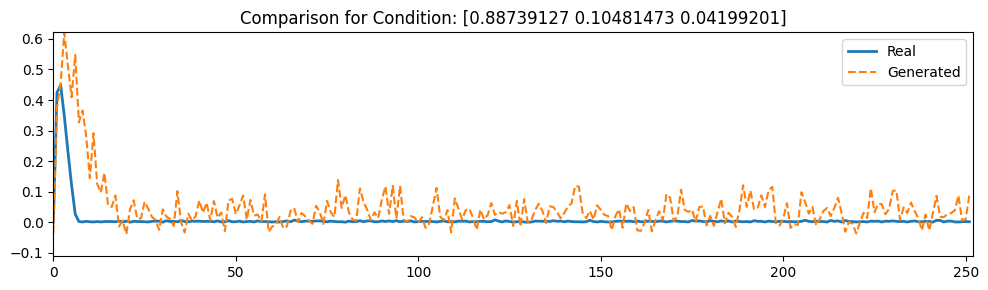

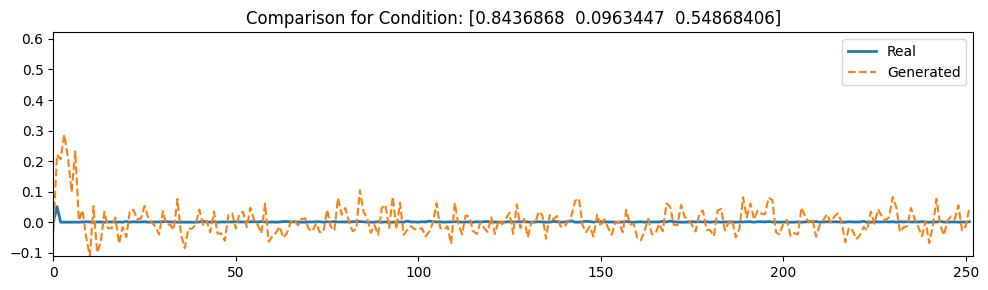

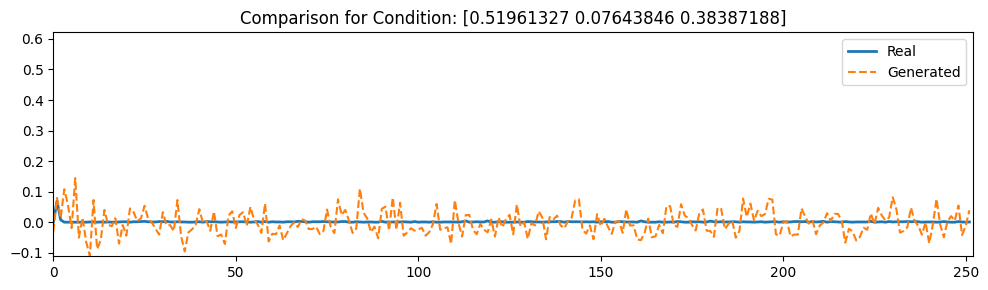

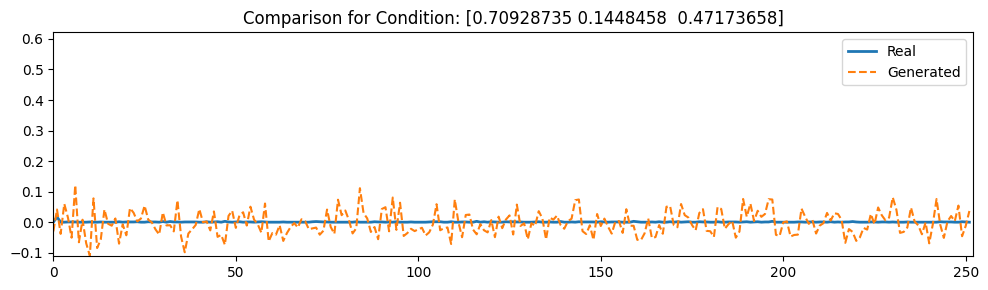

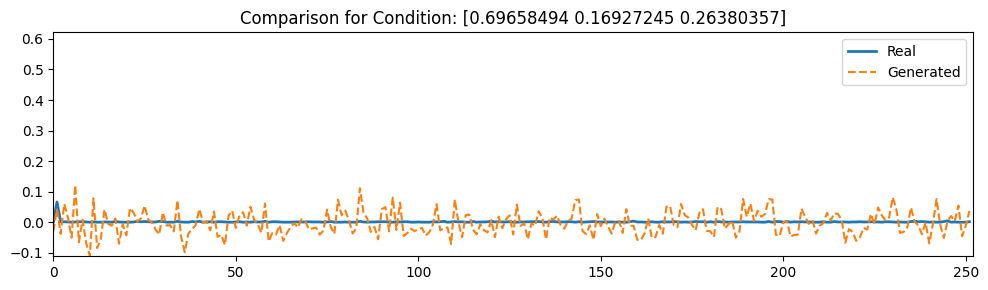

In [209]:
import matplotlib.pyplot as plt

# Calculate the global min and max for both real and generated samples
min_val = min(real_samples.min(), generated_samples.min())
max_val = max(real_samples.max(), generated_samples.max())

# Assuming real_samples, generated_samples, and real_conditions are already in the correct shape

for i in range(n_samples):
    plt.figure(figsize=(10, 3))
    plt.plot(real_samples[i].cpu().numpy(), label="Real", linewidth=2)
    plt.plot(generated_samples[i].cpu().numpy(), label="Generated", linestyle="--")
    
    # Set the axis limits based on global min and max
    plt.xlim(0, len(real_samples[i]))  # Standardize x-axis (if you know your x range)
    plt.ylim(min_val, max_val)  # Standardize y-axis

    plt.title(f"Comparison for Condition: {real_conditions[i].cpu().numpy()}")
    plt.legend()
    plt.tight_layout()
    plt.show()